In [1]:
import os
import skimage.io as skio
import skimage.transform as skit
import skimage.exposure as skie
import numpy as np
import pulse2percept as p2p

%matplotlib notebook
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-06-08 21:52:02,854 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
def combine_imgs(imgfile1, imgfile2):
    img1 = skie.rescale_intensity(skio.imread(imgfile1, dtype=np.float32))
    img2 = skie.rescale_intensity(skio.imread(imgfile2, dtype=np.float32))
    if img1.shape[0] < img2.shape[0]:
        img2 = skit.resize(img2, img1.shape, mode='reflect')
    else:
        img1 = skit.resize(img1, img2.shape, mode='reflect')
    return np.concatenate((img1, img2), axis=1), img1, img2

In [3]:
subject = '52-001'
fbase = os.path.join(os.environ['ARGUS_FUNDUS_DATA'], subject, '52-001-20090429-2OD-Fundus_Baseline_HDR_marked.jpg')
fm24 = os.path.join(os.environ['ARGUS_FUNDUS_DATA'], subject, '52-001-20090903-15OD-Fundus_3Months_HDR.jpg')

In [4]:
img_combined, img1, img2 = combine_imgs(fbase, fm24)

In [5]:
img1_warped = img_combined[:, :img_combined.shape[1] // 2, :]

<IPython.core.display.Javascript object>


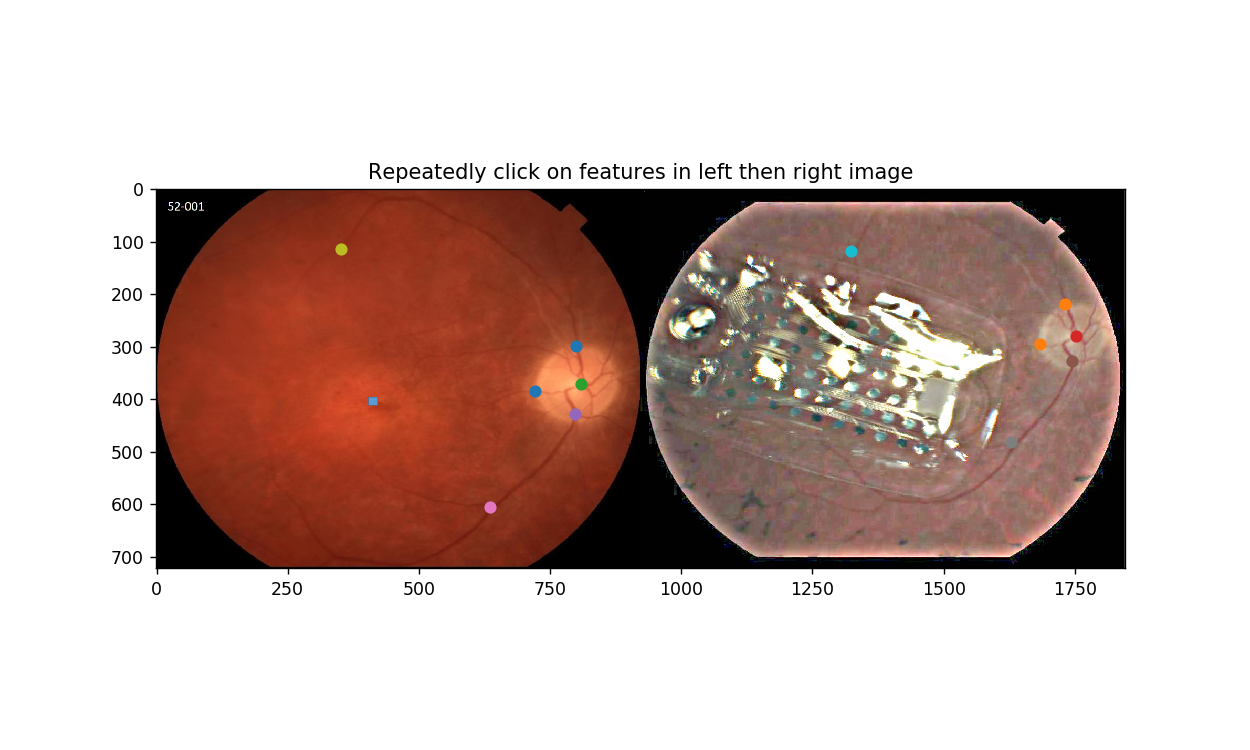

In [6]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.imshow(img_combined)
ax1.set_title('Repeatedly click on features in left then right image')
collector = []

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    collector.append((event.ydata, event.xdata))
    ax1.plot(event.xdata, event.ydata, 'o')
    text.set_text(tx)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [7]:
collector

[(298.11688141853597, 799.17530486076112),
 (219.51301045079413, 1730.5120790543094),
 (371.95688141853589, 808.70304679624496),
 (279.06139754756828, 1751.9494984091482),
 (429.12333303143919, 796.79336937689004),
 (326.70010722498762, 1744.8036919575352),
 (605.38655883789068, 634.82175647366432),
 (481.52591367660045, 1628.088853247858),
 (114.70784916047148, 351.37143389301912),
 (117.08978464434256, 1323.201111312374),
 (383.86655883789081, 720.57143389301916),
 (295.73494593466501, 1682.8733693768902)]

In [8]:
pts_source = np.array(collector[::2])
pts_target = np.array(collector[1::2])
pts_target[:, 1] -= img1_warped.shape[1]

In [9]:
tf = skit.estimate_transform('similarity', np.fliplr(pts_target), np.fliplr(pts_source))

In [10]:
img2_warped = skit.warp(img2, inverse_map=tf.inverse,
                        output_shape=img1_warped.shape)

In [11]:
mask = (img1_warped != 0) & (img2_warped != 0)

In [12]:
registered = img1_warped + img2_warped
registered[mask] /= 2

<IPython.core.display.Javascript object>


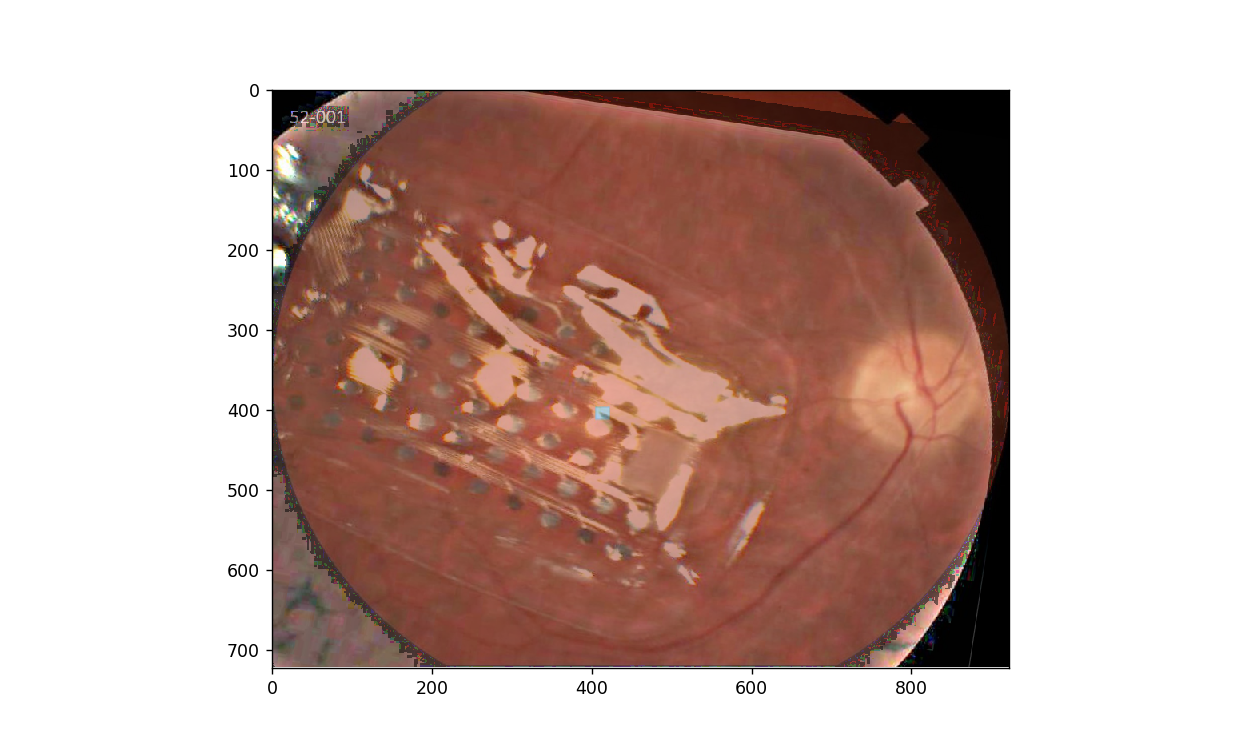

In [13]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(registered)
fig.savefig('%s-registered.png' % subject)

<IPython.core.display.Javascript object>


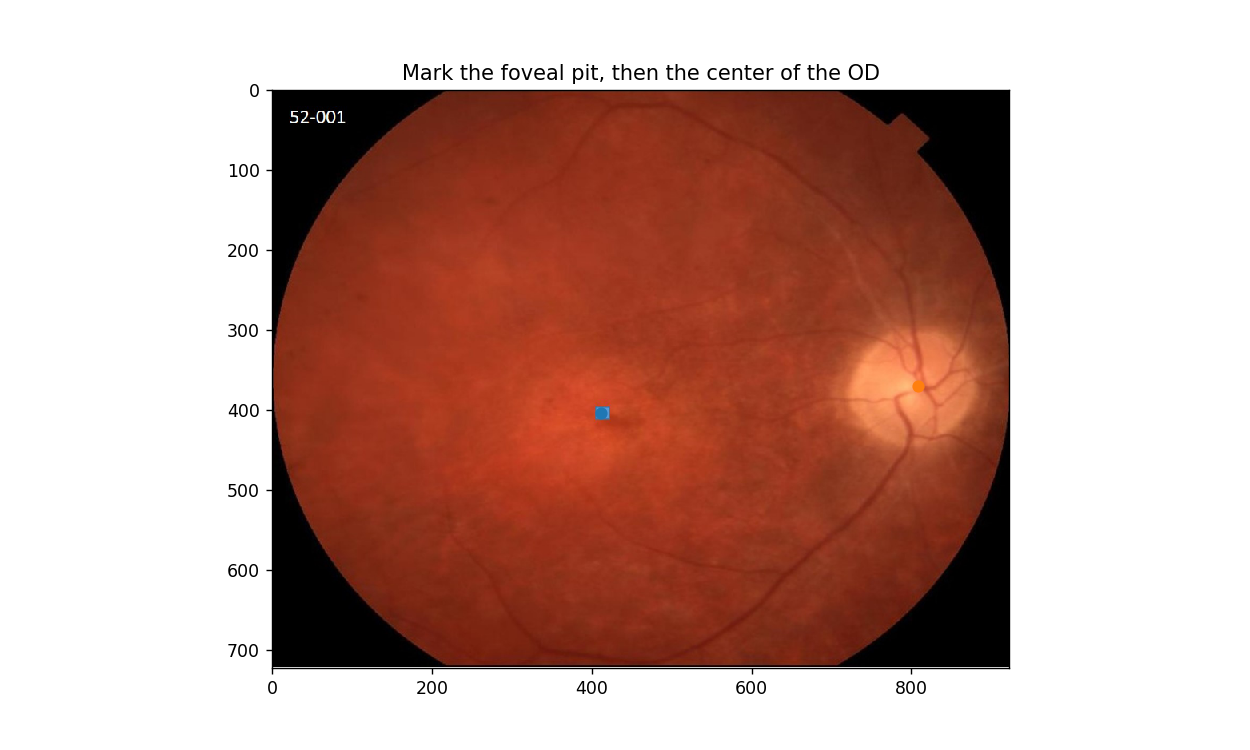

In [14]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.imshow(img1_warped)
ax1.set_title('Mark the foveal pit, then the center of the OD')
collector = []

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    collector.append((event.ydata, event.xdata))
    ax1.plot(event.xdata, event.ydata, 'o')
    text.set_text(tx)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [15]:
foveal_pit = collector[0]
optic_disc = collector[1]
foveal_pit, optic_disc

((403.56622899043089, 411.27419786329381),
 (370.70259262679451, 808.76770435680032))

<IPython.core.display.Javascript object>


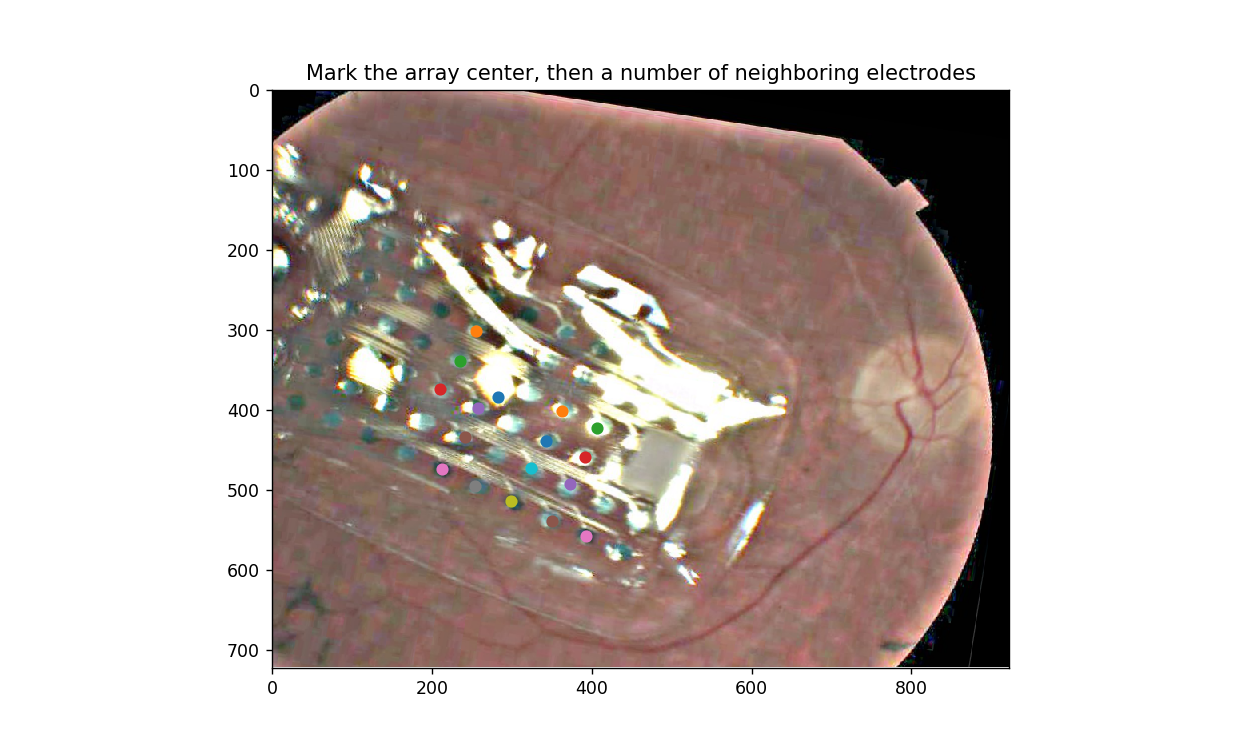

In [16]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.imshow(img2_warped)
ax1.set_title('Mark the array center, then a number of neighboring electrodes')
# ax1.text(0, 0, 'base image', color='w',
#          horizontalalignment='left',
#          verticalalignment='top')
collector = []

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    collector.append((event.ydata, event.xdata))
    ax1.plot(event.xdata, event.ydata, 'o')
    text.set_text(tx)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [17]:
arr_center = collector[0]
eloc = np.array(collector[1:])

In [18]:
eldist = np.mean(np.sqrt(np.diff(eloc[:, 0]) ** 2 + np.diff(eloc[:, 1]) ** 2))
eldist

45.216134056910164

<IPython.core.display.Javascript object>


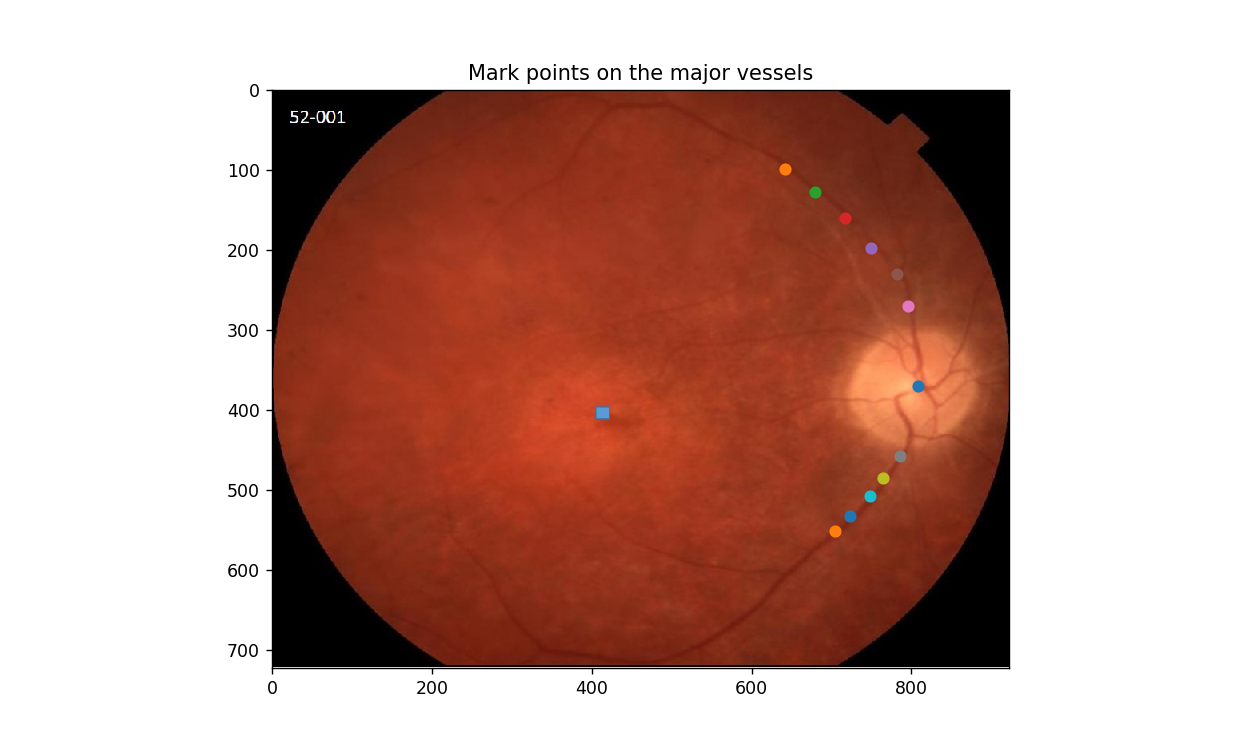

In [19]:
fig = plt.figure(figsize=(10, 6))
ax11 = fig.add_subplot(111)
ax11.imshow(img1_warped)
ax11.plot(optic_disc[1], optic_disc[0], 'o')
ax11.set_title('Mark points on the major vessels')
# ax1.text(0, 0, 'base image', color='w',
#          horizontalalignment='left',
#          verticalalignment='top')
collector = []

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    collector.append((event.xdata, event.ydata))
    ax11.plot(event.xdata, event.ydata, 'o')
    text.set_text(tx)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [20]:
vertex = optic_disc[::-1]
vessel = collector
vessel

[(641.31965240874842, 99.029855802461611),
 (678.8780939671899, 127.19868697129277),
 (716.4365355256316, 160.06232333492915),
 (749.30017188926786, 197.62076489337073),
 (782.16380825290412, 230.48440125700711),
 (796.24822383731976, 269.60777788038376),
 (785.29367838277426, 457.39998567259153),
 (764.94952253861857, 485.56881684142269),
 (747.73523682433279, 507.47790775051357),
 (722.69627578537165, 532.51686878947464),
 (703.91705500615103, 551.29608956869538)]

In [21]:
def rmse(x, pts, vertex):
    a, theta = x
    mse = 0
    for p in pts:
        y = (p[0] - vertex[0]) * np.sin(theta) + (p[1] - vertex[1]) * np.cos(theta)
        x = (p[0] - vertex[0]) * np.cos(theta) - (p[1] - vertex[1]) * np.sin(theta)
        mse += (a * y ** 2 - x) ** 2
    return np.sqrt(mse)

In [22]:
from scipy.optimize import minimize
ret = minimize(rmse, [0, 0], args=(vessel, vertex), method='Nelder-Mead')
ret

 final_simplex: (array([[-0.00263864, -0.06830498],
       [-0.00263862, -0.0682634 ],
       [-0.0026394 , -0.06837268]]), array([ 18.68159638,  18.68162387,  18.68163789]))
           fun: 18.681596381886955
       message: 'Optimization terminated successfully.'
          nfev: 90
           nit: 48
        status: 0
       success: True
             x: array([-0.00263864, -0.06830498])

In [23]:
best_a, best_theta = ret['x']
best_raphe = np.array([-np.cos(best_theta), np.sin(best_theta)])
best_a, np.rad2deg(best_theta)

(-0.0026386391842822912, -3.9135870595082762)

In [24]:
def find_x(pt_x, pt_y, vertex, a, theta):
    y = (pt_x - vertex[0]) * np.sin(theta) + (pt_y - vertex[1]) * np.cos(theta)
    x = (pt_x - vertex[0]) * np.cos(theta) - (pt_y - vertex[1]) * np.sin(theta)
    return (a * y ** 2 - x) ** 2

In [25]:
img1_warped.shape

(723, 923, 3)

In [26]:
y_para = np.linspace(img1_warped.shape[0] * 0.15, img1_warped.shape[0] * 0.85, 31)
x_para = []
for yy in y_para:
    r = minimize(find_x, 0, args=(yy, vertex, best_a, best_theta), method='Nelder-Mead')
    x_para.append(r['x'][0])

In [27]:
def dist(p, l1, l2):
    x0, y0 = p
    x1, y1 = l1
    x2, y2 = l2
    numer = np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denom = np.sqrt((y2-y1)**2 + (x2-x1)**2)
    return numer / denom

In [28]:
proj_foveal_pit = dist(foveal_pit[::-1], vertex, vertex + best_raphe) * np.array([-best_raphe[1], best_raphe[0]])
proj_foveal_pit += foveal_pit[::-1]

<IPython.core.display.Javascript object>


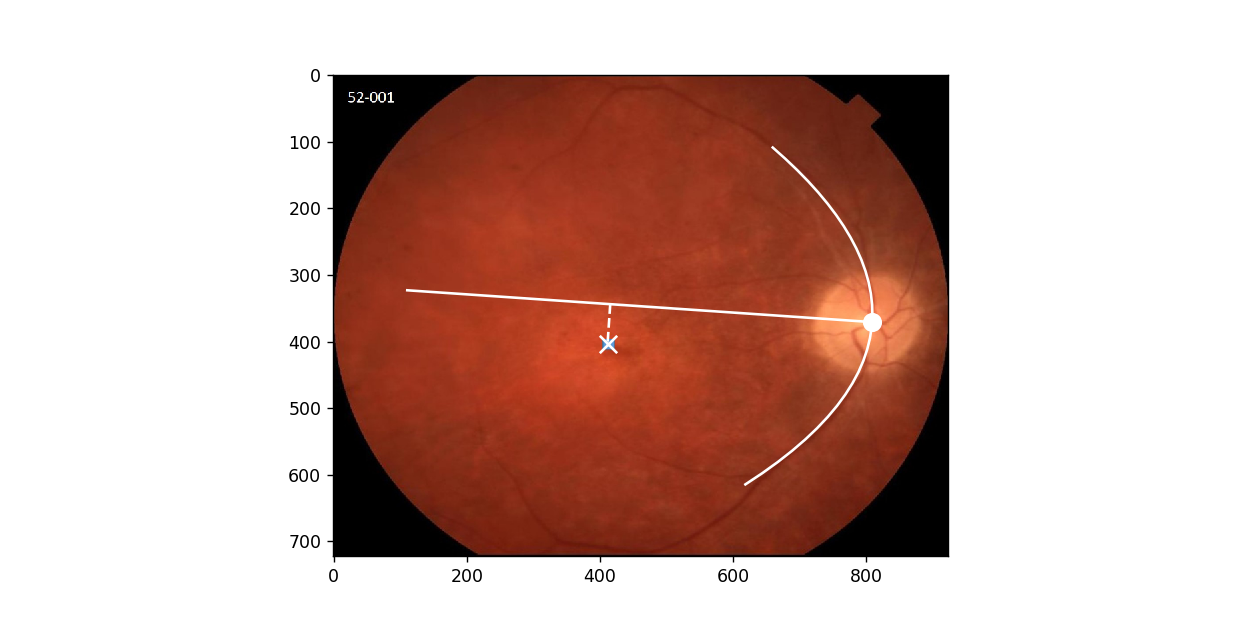

In [29]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.imshow(img1_warped, cmap='gray')
ax.plot(x_para, y_para, 'w')
ax.plot([vertex[0], vertex[0] + 700 * best_raphe[0]],
        [vertex[1], vertex[1] + 700 * best_raphe[1]], 'w')
ax.scatter(vertex[0], vertex[1], c='w', s=100, marker='o')
ax.scatter(foveal_pit[1], foveal_pit[0], c='w', s=100, marker='x')
ax.plot([proj_foveal_pit[0], foveal_pit[1]], [proj_foveal_pit[1], foveal_pit[0]], 'w--')
plt.savefig('%s-raphe-fovea.png' % subject)

In [30]:
euclid = skit.EuclideanTransform(rotation=best_theta)

In [31]:
rf_foveal_pit = euclid(foveal_pit[::-1])[0]
rf_proj_foveal_pit = euclid(proj_foveal_pit)[0]
rf_vertex = euclid(vertex)[0]
rf_arr_center = euclid(arr_center[::-1])[0]
rf_eloc = euclid(np.fliplr(eloc))

In [32]:
x_px = np.sqrt((vertex[0] - proj_foveal_pit[0]) ** 2 + (vertex[1] - proj_foveal_pit[1]) ** 2)
y_px = np.sqrt((proj_foveal_pit[0] - foveal_pit[1]) ** 2 + (proj_foveal_pit[1] - foveal_pit[0]) ** 2)

rf_x_px = np.sqrt((rf_vertex[0] - rf_proj_foveal_pit[0]) ** 2 + (rf_vertex[1] - rf_proj_foveal_pit[1]) ** 2)
rf_y_px = np.sqrt((rf_proj_foveal_pit[0] - rf_foveal_pit[0]) ** 2 + (rf_proj_foveal_pit[1] - rf_foveal_pit[1]) ** 2)

assert np.isclose(x_px, rf_x_px)
assert np.isclose(y_px, rf_y_px)

In [33]:
export_loc_od = p2p.retina.ret2dva(x_px / eldist * 525), p2p.retina.ret2dva(y_px / eldist * 525)
print('Center of optic nerve head in deg from the foveal pit:')
export_loc_od

Center of optic nerve head in deg from the foveal pit:


(16.964070582475607, 2.5004598505434008)

In [34]:
print('Array center in um from the foveal pit:')
export_arr_center = (rf_arr_center - rf_foveal_pit) * np.array([525 / eldist, -525 / eldist])
export_arr_center

Array center in um from the foveal pit:


array([-1502.11651555,   126.71916313])

In [35]:
angles = []
for j in range(1, rf_eloc.shape[0]):
    v1 = rf_eloc[j - 1, :] - rf_eloc[j, :]
    v2 = [1, 0]
    angle = np.rad2deg(np.arccos(np.dot(v1, v2) / np.linalg.norm(v1) / np.linalg.norm(v2)))
    if angle > 90:
        angle = 180 - angle
    if angle > 45:
        angle = 90 - angle
    angles.append(angle)
angles

[24.529341564855116,
 30.910902097448563,
 21.907404914681052,
 21.646378112315503,
 30.781566471725647,
 22.651464117569674,
 18.565847337594931,
 27.693915186740611,
 24.696872606456978,
 24.529341564854988,
 22.651464117569731,
 19.584978616443721,
 24.696872606456949,
 21.855740564830498,
 20.048901915069933]

In [36]:
print('Array orientation in rad and deg:')
export_rot = -np.deg2rad(np.mean(angles))
export_rot, np.rad2deg(export_rot)

Array orientation in rad and deg:


(-0.41509862777141915, -23.783399452974262)

# Results

In [37]:
rf_img = skit.warp(registered, euclid.inverse)

<IPython.core.display.Javascript object>


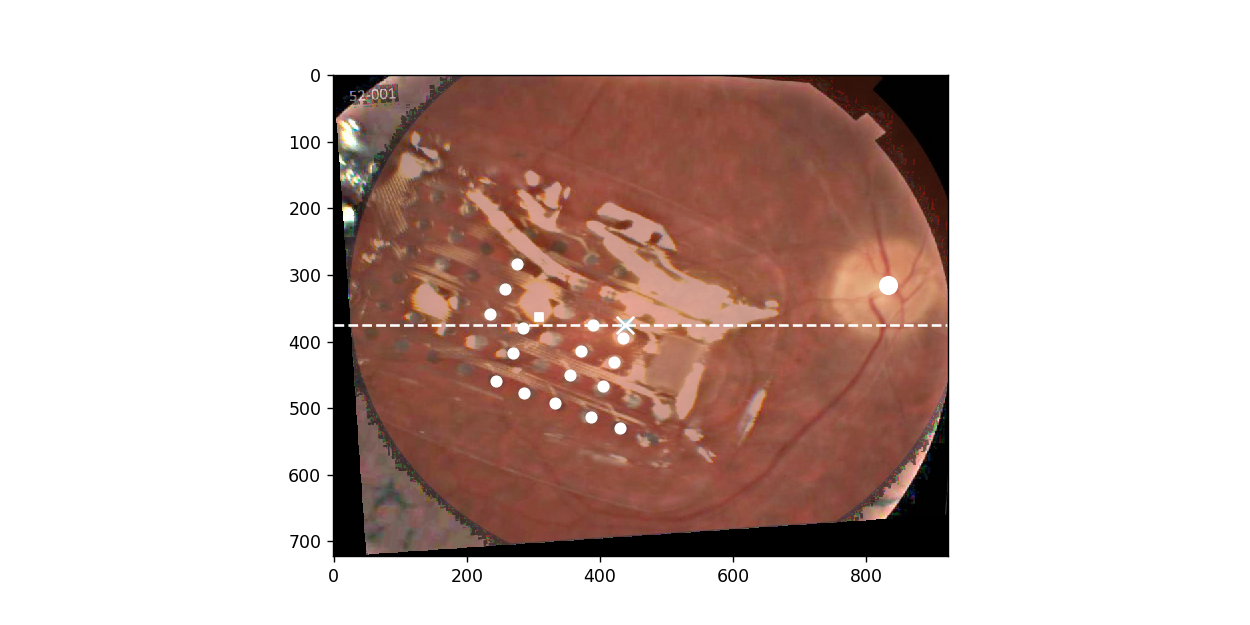

In [38]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.imshow(rf_img, cmap='gray')
ax.plot(rf_eloc[:, 0], rf_eloc[:, 1], 'ow')
ax.scatter(rf_vertex[0], rf_vertex[1], c='w', s=100, marker='o')
ax.scatter(rf_foveal_pit[0], rf_foveal_pit[1], c='w', s=100, marker='x')
ax.scatter(rf_arr_center[0], rf_arr_center[1], c='w', s=20, marker='s')
ax.plot([0, registered.shape[1] - 1], [rf_foveal_pit[1], rf_foveal_pit[1]], 'w--')
fig.savefig('%s-registered-annot.png' % subject)

In [39]:
print('Center of optic nerve head in deg from the foveal pit:', export_loc_od)
print('Array center in um from the foveal pit:', export_arr_center)
print('Array orientation in rad and deg:', export_rot, np.rad2deg(export_rot))

Center of optic nerve head in deg from the foveal pit: (16.964070582475607, 2.5004598505434008)
Array center in um from the foveal pit: [-1502.11651555   126.71916313]
Array orientation in rad and deg: -0.415098627771 -23.783399453


# p2p

In [ ]:
argus = p2p.implants.ArgusII(x_center=export_arr_center[0],
                             y_center=export_arr_center[1],
                             rot=export_rot)

In [ ]:
sim = p2p.Simulation(argus)

In [ ]:
sim.set_optic_fiber_layer(sampling=506, loc_od=export_loc_od)

In [ ]:
fig, ax = sim.plot_fundus()
ax.grid('on', which='major')
fig.savefig('%s-sim.png' % subject)

In [ ]:
argus_LE = p2p.implants.ArgusII(x_center=-export_arr_center[0],
                             y_center=export_arr_center[1],
                             rot=-export_rot,
                             eye='LE')
sim = p2p.Simulation(argus_LE)

In [ ]:
sim.set_optic_fiber_layer(sampling=506, loc_od=(-export_loc_od[0], export_loc_od[1]))

In [ ]:
fig, ax = sim.plot_fundus(upside_down=True)
ax.grid('on', which='major')
fig.savefig('%s-sim.png' % subject)